### use autoencoder generate MNIST dataset 

In [1]:
__author__ = 'SherlockLiao'

### import necessary package

In [2]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST

### define function to transfer tensor to Variable or cuda.Variable

In [3]:
def to_var(x):
    x = Variable(x)
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x

### define function to transfer tensor to a image

In [4]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

### define hyperparameters

In [5]:
num_epochs = 70
batch_size = 128
learning_rate = 1e-3

### defein image dataset and image transforms

In [6]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = MNIST('./data', transform=img_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### define MLP autoencoder

In [7]:
class encoder(nn.Module):
    def __init__(self):
        super(encoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 3)
        )

    def forward(self, x):
        x = self.fc(x)
        return x

In [8]:
class decoder(nn.Module):
    def __init__(self):
        super(decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        return x

In [9]:
if torch.cuda.is_available():
    en_model = encoder().cuda()
    de_model = decoder().cuda()
else:
    en_model = encoder()
    de_model = decoder()

### define loss and optimizer

In [10]:
parm = list(en_model.parameters()) + list(de_model.parameters())
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(parm, lr=learning_rate)

### train mlp autoencoder

In [11]:
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        num_img = img.size(0)
        img = img.view(num_img, -1)
        img = to_var(img)
        # ===================forward=====================
        code = en_model(img)
        output = de_model(code)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, loss.data[0]))
    if epoch % 20 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './img/image_{}.png'.format(epoch))

epoch [1/70], loss:0.1774
epoch [2/70], loss:0.1581
epoch [3/70], loss:0.1690
epoch [4/70], loss:0.1515
epoch [5/70], loss:0.1424
epoch [6/70], loss:0.1459
epoch [7/70], loss:0.1504
epoch [8/70], loss:0.1511
epoch [9/70], loss:0.1417
epoch [10/70], loss:0.1455
epoch [11/70], loss:0.1444
epoch [12/70], loss:0.1350
epoch [13/70], loss:0.1325
epoch [14/70], loss:0.1325
epoch [15/70], loss:0.1400
epoch [16/70], loss:0.1417
epoch [17/70], loss:0.1250
epoch [18/70], loss:0.1424
epoch [19/70], loss:0.1345
epoch [20/70], loss:0.1310
epoch [21/70], loss:0.1240
epoch [22/70], loss:0.1330
epoch [23/70], loss:0.1429
epoch [24/70], loss:0.1364
epoch [25/70], loss:0.1248
epoch [26/70], loss:0.1267
epoch [27/70], loss:0.1234
epoch [28/70], loss:0.1297
epoch [29/70], loss:0.1232
epoch [30/70], loss:0.1256
epoch [31/70], loss:0.1275
epoch [32/70], loss:0.1329
epoch [33/70], loss:0.1200
epoch [34/70], loss:0.1269
epoch [35/70], loss:0.1255
epoch [36/70], loss:0.1164
epoch [37/70], loss:0.1258
epoch [38/

### save model

In [115]:
torch.save(en_model.state_dict(), './encoder.pth')
torch.save(de_model.state_dict(), './decoder.pth')

### given a random code to generate img

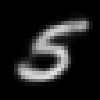

In [114]:
code = to_var(torch.Tensor([8, 2.3, -0.4]))
code = code.unsqueeze(0)

out = de_model(code)

img = to_img(out)

import PIL

a = torchvision.transforms.ToPILImage()(img.cpu().data.squeeze(0))

a.resize((100, 100))